In [11]:
import os
# 加载数据
train_image_list = os.listdir("DATA/train")
test_image_list = os.listdir("DATA/test")

In [12]:
# 划分数据集
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(
    range(len(train_image_list)),
    test_size=0.2,
    random_state=42,
    stratify=[img.split('.')[0] for img in train_image_list]
)
train_files = [train_image_list[i] for i in train_indices]
val_files = [train_image_list[i] for i in val_indices]

In [7]:
import torchvision.transforms as transforms

In [27]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [18]:
from torch.utils.data import Dataset, DataLoader
# 数据集
import cv2
class ImageDataset(Dataset):
    def __init__(self,images, data_folder, transforms=None, is_train=True):
        # self.X = images
        # self.y = labels
        self.X = [img.split('.')[0] for img in images]
        self.is_train = is_train
        self.image_list = images
        self.data_folder = data_folder
        self.transforms = transforms

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        img_name = self.image_list[i]
        img_path = os.path.join(self.data_folder, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)
        if self.is_train:
            label = 1 if img_name.startswith('dog') else 0
            return image, label
        else:
            return image, img_name.split('.')[0]

In [28]:
train_data = ImageDataset(train_files, "DATA/train", transforms=train_transform)
val_data = ImageDataset(val_files, "DATA/train", val_transform)
test_data = ImageDataset(test_image_list, "DATA/test", transforms=val_transform, is_train=False)

In [29]:
BATCH_SIZE = 64
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader= DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)
testloader= DataLoader(test_data, batch_size=BATCH_SIZE,shuffle=False)

In [22]:
import torch
import torchvision.models
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练模型
model = torchvision.models.resnet34(pretrained='imagenet')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 修改最后一层为2分类
model.to(device)

model = nn.DataParallel(model)  # 使用多GPU训练

In [23]:

# 定义损失函数和优化器
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [34]:
def fit(model, dataloader):
    model.train()

    # 初始化模型损失以及模型 top-1 错误率
    running_loss =0.0
    running_top1_error = 0

    # 开始迭代
    for i, data in enumerate(dataloader):
        # 准备好训练的图像和标签，每次传入的数据是batch_size张图像
        x, y = data[0].to(device), data[1].to(device)
        # 需要在开始反向传播之前将梯度设置为0
        # 因为pytorch会在随后的反向传递中累计梯度
        optimizer.zero_grad()

        # 将数据传入模型中，获得输出的标签
        outputs = model(x)

        # 将预测标签与真是标签计算损失
        loss = criterion(outputs, y)

        # 记录当前损失
        running_loss += loss.item()

        # 记录当前top-1错误率
        _, preds = torch.max(outputs.data, 1)
        running_top1_error += torch.sum(preds != y)

        # 反向传播
        loss.backward()
        optimizer.step()

    loss = running_loss / len(dataloader.dataset)
    top1_error = running_top1_error / len(dataloader.dataset)

    print(f"Loss: {loss:.4f}, Top-1 Error: {top1_error:.4f}")
    return loss, top1_error

In [37]:
# 定义验证函数
def validate(model, dataloader):
    model.eval()

    # 初始化模型损失以及模型 top-1 错误率
    running_loss = 0.0
    running_top1_error = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            x, y = data[0].to(device), data[1].to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_top1_error += torch.sum(preds != y)

        loss = running_loss / len(dataloader.dataset)
        top1_error = running_top1_error / len(dataloader.dataset)
        print(f"Validation Loss: {loss:.4f}, Top-1 Error: {top1_error:.4f}")
        return loss, top1_error

In [38]:
epochs = 25

train_loss , train_top1_error = [], []
val_loss, val_top1_error = [], []

print(f"Traininf on {len(train_data)} examples, validating on {len(val_data)} examples")

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    train_epoch_loss, train_epoch_top1_error = fit(model, trainloader)
    val_epoch_loss, val_epoch_top1_error = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_top1_error.append(train_epoch_top1_error.cpu())
    val_loss.append(val_epoch_loss)
    val_top1_error.append(val_epoch_top1_error.cpu())


Traininf on 20000 examples, validating on 5000 examples
Epoch 1/25
Loss: 0.0002, Top-1 Error: 0.0039
Validation Loss: 0.0005, Top-1 Error: 0.0110
Epoch 2/25
Loss: 0.0002, Top-1 Error: 0.0037
Validation Loss: 0.0007, Top-1 Error: 0.0128
Epoch 3/25
Loss: 0.0002, Top-1 Error: 0.0032
Validation Loss: 0.0007, Top-1 Error: 0.0158
Epoch 4/25
Loss: 0.0001, Top-1 Error: 0.0019
Validation Loss: 0.0006, Top-1 Error: 0.0126
Epoch 5/25
Loss: 0.0001, Top-1 Error: 0.0019
Validation Loss: 0.0007, Top-1 Error: 0.0132
Epoch 6/25
Loss: 0.0001, Top-1 Error: 0.0023
Validation Loss: 0.0008, Top-1 Error: 0.0146
Epoch 7/25
Loss: 0.0001, Top-1 Error: 0.0025
Validation Loss: 0.0006, Top-1 Error: 0.0104
Epoch 8/25
Loss: 0.0001, Top-1 Error: 0.0024
Validation Loss: 0.0005, Top-1 Error: 0.0106
Epoch 9/25
Loss: 0.0000, Top-1 Error: 0.0012
Validation Loss: 0.0008, Top-1 Error: 0.0138
Epoch 10/25
Loss: 0.0000, Top-1 Error: 0.0007
Validation Loss: 0.0007, Top-1 Error: 0.0108
Epoch 11/25
Loss: 0.0000, Top-1 Error: 0.00

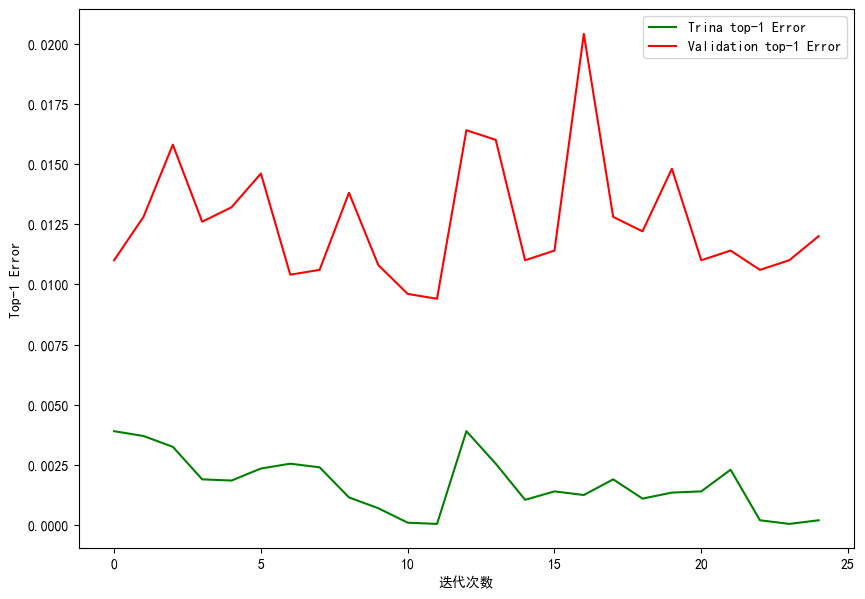

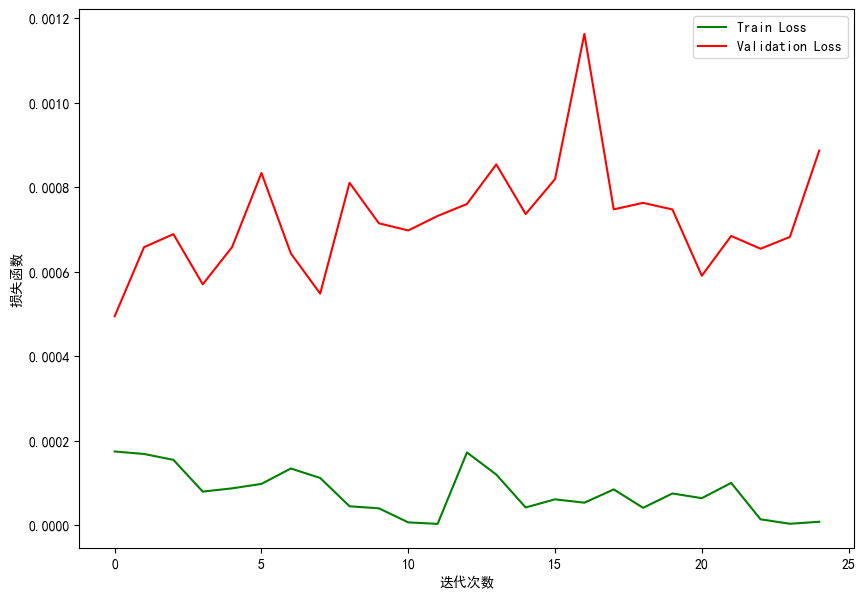

In [39]:
# 绘制曲线
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10,7))

plt.plot(train_top1_error, color='green', label='Trina top-1 Error')
plt.plot(val_top1_error, color='red', label='Validation top-1 Error')

plt.xlabel('迭代次数')
plt.ylabel('Top-1 Error')
plt.legend()

# 绘制损失函数曲线
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='green', label='Train Loss')
plt.plot(val_loss, color='red', label='Validation Loss')
plt.xlabel('迭代次数')
plt.ylabel('损失函数')
plt.legend()

In [40]:
# 对测试集进行预测
import numpy as np

def predict(model, dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in dataloader:
            x, _ = data[0].to(device), data[1]
            outputs = model(x)
            _, preds = torch.max(outputs.data, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions
test_predictions = predict(model, testloader)


In [41]:
# csv文件保存预测结果
import pandas as pd
def save_predictions(predictions, output_file):
    df = pd.DataFrame({'id': [f.split('.')[0] for f in test_image_list], 'label': predictions})
    df.to_csv(output_file, index=False)
save_predictions(test_predictions, 'submission.csv')
